# Time Series Model Validation Demo

## 1. Introduction

## 2. Setup 

Prepare the environment for our analysis. First, **import** all necessary libraries and modules required for our analysis. Next, **connect** to the ValidMind MRM platform, which provides a comprehensive suite of tools and services for model validation.

Finally, define and **configure** the specific use case we are working on by setting up any required parameters, data sources, or other settings that will be used throughout the analysis. 

### Import Libraries

In [1]:
# Load API key and secret from environment variables
%load_ext dotenv
%dotenv .env

# ValidMind libraries 
import validmind as vm

### Connect to the ValidMind Library

In [2]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  project = "clhhz04x40000wcy6shay2oco"
)

Connected to ValidMind. Project: Customer Churn Model - Initial Validation (clhhz04x40000wcy6shay2oco)


### Find All Test Plans Available in the Developer Framework

In [3]:
vm.test_plans.list_plans()

ID,Name,Description
binary_classifier_metrics,BinaryClassifierMetrics,Test plan for sklearn classifier metrics
binary_classifier_validation,BinaryClassifierPerformance,Test plan for sklearn classifier models
binary_classifier_model_diagnosis,BinaryClassifierDiagnosis,Test plan for sklearn classifier model diagnosis tests
binary_classifier,BinaryClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.


## 3. Load Models

#### Load Pre-Trained Time Series Models

In [4]:
# Currently only fred pre-trained models are available
from validmind.datasets.regression import fred as demo_dataset
model_A, train_df_A, test_df_A = demo_dataset.load_model('fred_loan_rates_model_1')
model_B, train_df_B, test_df_B = demo_dataset.load_model('fred_loan_rates_model_3')

#### Create ValidMind Datasets

In [5]:
vm_train_ds_A = vm.init_dataset(dataset=train_df_A, type="generic", target_column=demo_dataset.target_column)
vm_test_ds_A = vm.init_dataset(dataset=test_df_A, type="generic", target_column=demo_dataset.target_column)

vm_train_ds_B = vm.init_dataset(dataset=train_df_B, type="generic", target_column=demo_dataset.target_column)
vm_test_ds_B = vm.init_dataset(dataset=test_df_B, type="generic", target_column=demo_dataset.target_column)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


#### Create ValidMind Models

In [6]:
vm_model_A = vm.init_model(
    model = model_A, 
    train_ds=vm_train_ds_A, 
    test_ds=vm_test_ds_A)
vm_model_B = vm.init_model(
    model = model_B,
    train_ds=vm_train_ds_B,
    test_ds=vm_test_ds_B)

list_of_models = [vm_model_A, vm_model_B]

## 4. Model Diagnosis

#### **Run Time Series Model Summary Test Plan**

## 5. Model Evaluation

### Performance across Models

#### **Run Time Series Model Performance Test Plan**

### Forecast vs Observed across Models 

#### **Run Time Series Forecast Test Plan**

In [7]:
vm.test_plans.describe_plan("time_series_forecast")

Attribute,Value
ID,time_series_forecast
Name,TimeSeriesForecast
Description,Test plan to perform time series forecast tests.
Required Context,['models']
Tests,RegressionModelForecastPlot (Metric)
Test Plans,[]


{'start_date': None, 'end_date': None}
{'start_date': None, 'end_date': None}
0     1971-05-01
1     1971-06-01
2     1971-07-01
3     1971-08-01
4     1971-09-01
         ...    
119   2022-11-01
120   2022-12-01
121   2023-01-01
122   2023-02-01
123   2023-03-01
Name: DATE, Length: 622, dtype: datetime64[ns]


ValueError: Axis limits cannot be NaN or Inf

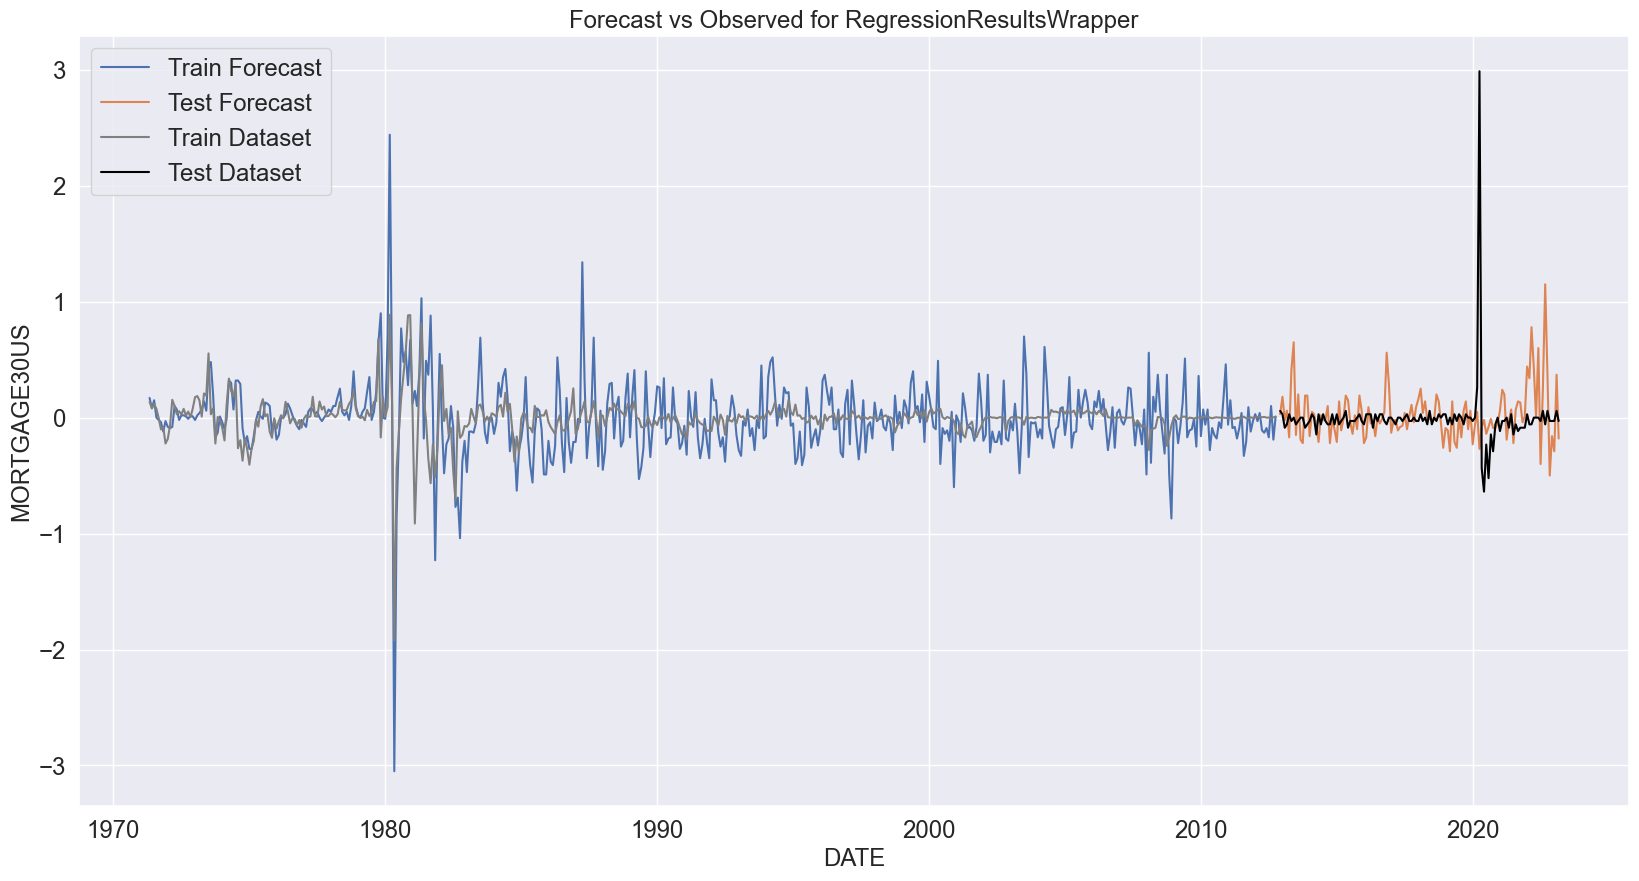

In [9]:
config= {
    "regression_forecast_plot": {
        "start_date": '2010-01-01',
        "end_date": '2022-01-01'
    }
}

vm.run_test_plan("time_series_forecast",
                                        models=list_of_models,
                                        config=config)